In [1]:
from analyze_images import *
from aberrations import *
import pyds9


In [22]:
coll = Collimate(filename="/home/bmcleod/src/CollTAOS/Configs/taos2.yaml", configname="TAOS2")


In [3]:
ds9 = pyds9.DS9()

# Parameters

In [ ]:
folder = '/data/piper0/bmcleod/2024-11-TAOS2/2024September_fits/site3/240925/fseq01/'
minus_image = "mosaic_2558.fits"
plus_image = "mosaic_2588.fits"
minus_focus = 2558
plus_focus = 2588

## Preliminaries: determine how the aberrations are expected to vary with field angle and miscollimation state

array([[-2.76003196e-01, -1.37648829e-03],
       [ 7.51748095e+00, -1.10799976e+00]])

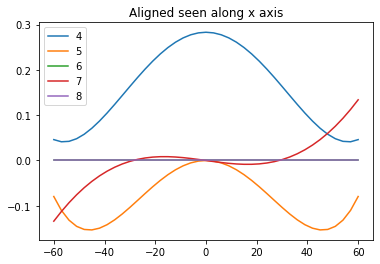

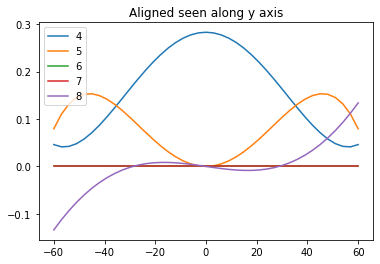

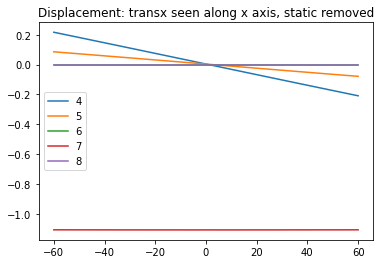

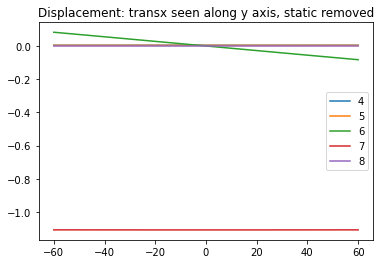

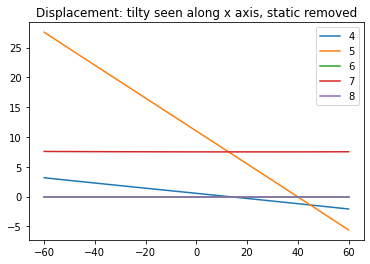

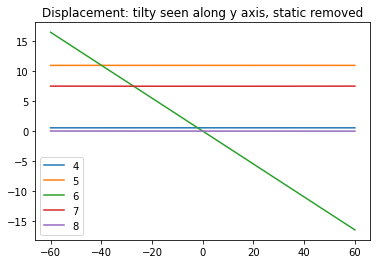

In [23]:
aber = Aberrations()
aber.read_zernike_data("/home/bmcleod/src/CollTAOS/Pokes/TAOS2/")

aber.fit_static_terms()
aber.compute_collimation_response_matrix()

### Extract postage stamps out of the master large image using regions in the current ds9 frame
It is assumed that the image has already been background subtracted.
 
 Put regions on a set of ~9 stars well distributed over the image.
 Make sure the regions are well centered on the stars


In [5]:
# Get the star positions from ds9 and save in a file
#
do_the_ds9=False

locations_file = folder + os.path.splitext(minus_image) + ".locations.txt"

if do_the_ds9:
    xy_locations = get_xy_from_ds9(ds9)
    print("Got these positions: ", xy_locations)
    locations_file = folder + os.path.splitext(minus_image) + ".locations.txt"
    save_star_locations(locations_file, xy_locations)

In [7]:
locations_file = folder + os.path.splitext(minus_image) + ".locations.txt"
xy_locations = load_star_locations(locations_file)
print(xy_locations)
coll.set_xy(xy_locations)
boxes_m = coll.extract_boxes_from_image(folder + minus_image)
boxes_p = coll.extract_boxes_from_image(folder + plus_image)

[[ 367.50675  8527.7838  ]
 [4965.7935   8263.7534  ]
 [8721.406    8558.2348  ]
 [  84.570785 5003.133   ]
 [4128.8747   4129.2571  ]
 [9240.657    4144.3262  ]
 [ 996.29801   269.77113 ]
 [5607.4454    669.07713 ]
 [9103.7243    479.03497 ]]


### Make an image for display purposes that shows all the postage stamps in the correct positions relative to each other, but magnified

In [21]:
magnification = 50

m_labels_region, m_layout = make_stamp_layout(boxes_m, xy_locations, magnification)
p_labels_region, p_layout = make_stamp_layout(boxes_p, xy_locations, magnification)

# Display in ds9
ds9.set("frame 1")
ds9.set_np2arr(m_layout)
ds9.set("regions", m_labels_region)

ds9.set("frame 2")
ds9.set_np2arr(p_layout)
ds9.set("regions", p_labels_region)



1

In [9]:
results = coll.fit_images(boxes_m, boxes_p, minus_focus, plus_focus)

Processing 0
Processing 1
Processing 2
Processing 3
Processing 4
Processing 5
Processing 6
Processing 7
Processing 8


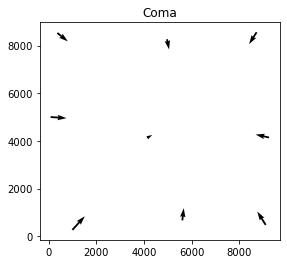

In [10]:
plot_coma(results)

Astigmatism fit:
  Constant terms: -0.18, -0.29
  Linear terms @ 60mm: 0.26, 0.45
  Quadratic term @ 60mm: 0.93
Focus fit
  Constant: 2568.52
  Linear @ 60mm: -0.30 -0.43
  Quadratic @ 60mm: 3.28
X coma fit
  Constant: 0.17
  Linear @ 60mm: -0.90
Y coma fit
  Constant: 0.09
  Linear @ 60mm: -0.98
(2, 10, 10)


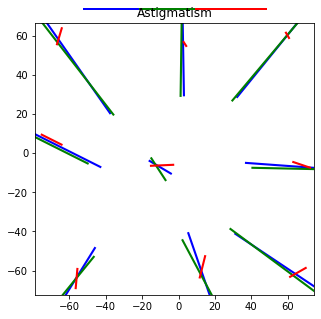

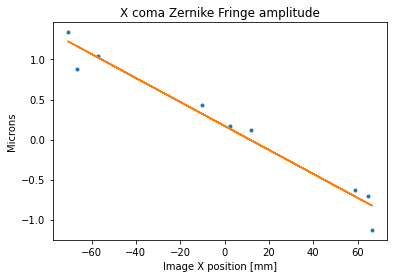

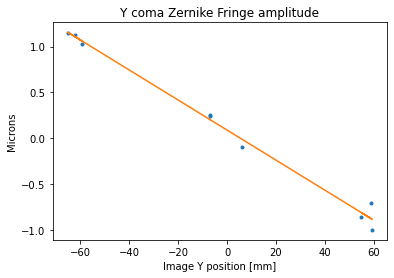

In [11]:
coll.fit_aberrations(results)

In [16]:
Tx, Ty, Ry, Rx = coll.determine_tilt_and_translation(coll.astigx, coll.astigy, coll.comax, coll.comay)

Translation X: -0.251 mm
Translation Y: -0.256 mm
Tilt about Y:  -0.014 deg
Tilt about X:   0.026 deg


### Convert to actuator motions

In [20]:
# Distances from mirror vertex to upper and lower actuators
Du = 300 # Estimate from photo
Dl = 100 # Estimate from photo
turns_per_mm = 1 / (1/24 - 1/28) / 25.4 # Matt needs to confirm

xu = Tx - np.radians(Ry) * Du
xl = Tx - np.radians(Ry) * Dl
yu = Ty + np.radians(Rx) * Du
yl = Ty + np.radians(Rx) * Dl


print (xu, xl, yu, yl)


turns_west_upper = yu * turns_per_mm
turns_west_lower = yl * turns_per_mm
turns_south_upper = xu * turns_per_mm
turns_south_lower = xl * turns_per_mm

print(f"Turns west upper: {turns_west_upper:.2f}")
print(f"Turns west lower: {turns_west_lower:.2f}")
print(f"Turns south upper: {turns_south_upper:.2f}")
print(f"Turns south lower:{turns_south_lower:.2f}")

-0.38707533724299736 -0.296338346808685 -0.33138696201804096 -0.2812534093099787
Turns west upper: -2.19
Turns west lower: -1.86
Turns south upper: -2.56
Turns south lower:-1.96


(2, 50, 50)
If collimated: True On-axis aberrations: [ 0.          0.          0.          0.         -0.18196677 -0.28694705
  0.          0.        ]


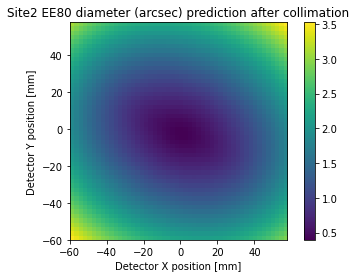

(2, 50, 50)
If collimated: False On-axis aberrations: [ 0.          0.          0.          0.         -0.18196677 -0.28694705
  0.17010701  0.08844366]


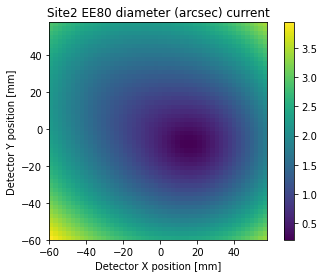

In [13]:
coll.make_image_quality_maps()


In [13]:
coll.show_stamp_layout_from_model_images(ds9)